# Programming Exercise 8 - Anomaly Detection and Recommender Systems

In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize
import seaborn as sns
sns.set(context="notebook", style="white")

# Anomaly Detection

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected $m = 307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \dots, x^{(m)}\}$. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

We start this exercise by using a small dataset that is easy to visualize. Our example case consists of 2 network server statistics across several machines: the latency and throughput of each machine.

In [2]:
data = loadmat('data/ex8data1.mat')

X, Xval, yval = data['X'], data['Xval'], data['yval']
X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

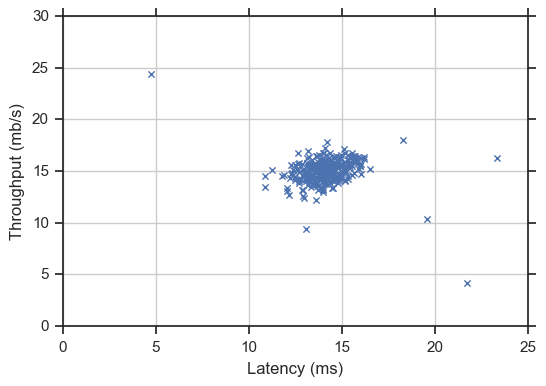

In [3]:
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c='b', marker='x')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.grid(True)

## Gaussian Distribution

To perform anomaly detection, you will first need to fit a model to the data's distribution. Given a training set $\{x^{(1)}, \dots, x^{(m)} \}$ (where $x^{(i)} \in \mathbb{R}^n$ ), you want to estimate the Gaussian distribution for each of the features $x_i$ . For each feature $i = 1 \dots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i^{th}$ dimension $\{ x_i^{(1)}, \dots, x_i^{(m)} \}$ (the $i^{th}$ dimension of each example).

The Gaussian distribution is given by

$$
p(x; \mu, \sigma^{2})=\frac{1}{\sqrt{2\pi}\sigma}e^{\frac{-(x-\mu)^2}{2\sigma^2}},
$$

where $\mu$ is the mean and $\sigma^2$ is the variance.

## Estimating parameters for a Gaussian

You can estimate the parameters $\left( \mu_i, \sigma_i^2 \right)$, of the $i^{th}$ feature by using the following equations. To estimate the mean, you will use:

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$
and for the variance you will use:

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

Your task is to complete the code in the function estimateGaussian. This function takes as input the data matrix X and should output an n-dimension vector mu that holds the mean for each of the $n$ features and another n-dimension vector sigma2 that holds the variances of each of the features. You can implement this using a for-loop over every feature and every training example (though a vectorized implementation might be more efficient; feel free to use a vectorized implementation if you prefer).

In [4]:
def estimateGaussian(X):
    m, n = X.shape
    
    mu = np.mean(X, axis=0)
    mu = mu.reshape(mu.shape[0], -1)
    sigma2 = np.var(X, axis=0)
    sigma2 = sigma2.reshape(sigma2.shape[0], -1)
    
    return mu, sigma2

Once you have completed the code in estimateGaussian, the next cell will visualize the contours of the fitted Gaussian distribution. To do the visualization of the Gaussian fit, we first estimate the parameters of our assumed Gaussian distribution, then compute the probabilities for each of the points and then visualize both the overall distribution and where each of the points falls in terms of that distribution.

Visualizing Gaussian fit.


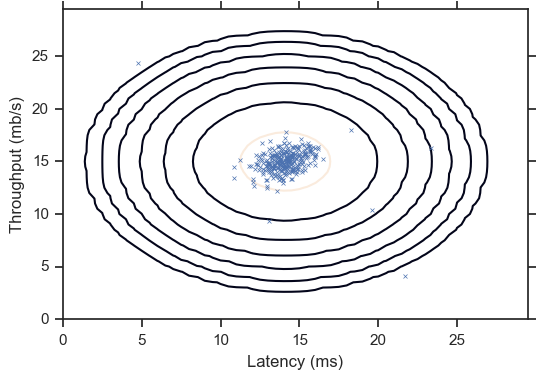

In [5]:
import scipy.linalg as linalg

def multivariateGaussian(X, mu, Sigma2):
    
    k = len(mu)

    if (Sigma2.shape[0] == 1) or (sigma2.shape[1] == 1):
        Sigma2 = linalg.diagsvd(Sigma2.flatten(),
                                len(Sigma2.flatten()),
                                len(Sigma2.flatten()))
        X = X - mu.T
        p = np.dot(np.power(2 * np.pi, - k / 2.0),
                   np.power(np.linalg.det(Sigma2), -0.5)) * \
        np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(Sigma2)) * X, axis=1))

    return p

def visualizeFit(X, mu, sigma2):
    
    X1, X2 = np.meshgrid(np.arange(0, 30, 0.5), np.arange(0, 30, 0.5))
    Z = multivariateGaussian(np.column_stack((X1.reshape(X1.size),
                                              X2.reshape(X2.size))),
                             mu, sigma2)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1],'bx', markersize=3)

    # Do not plot if there are infinities.
    if (np.sum(np.isinf(Z)) == 0):
        plt.contour(X1, X2, Z, np.power(10,(np.arange(-20, 0.1, 3)).T))

print('Visualizing Gaussian fit.')

# Estimate mu and sigma2.
mu, sigma2 = estimateGaussian(X)

# Return the density of the multivariate normal at each data point (row) of X.
p = multivariateGaussian(X, mu, sigma2)

# Visualize the fit.
visualizeFit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

From your plot, you can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

## Selecting the threshold,  $\varepsilon$

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.

You should now complete the code for the function selectThreshold. For this, we will use a cross validation set $\{ (x_{cv}^{(1)}, y_{cv}^{(1)}), \dots, (x_{cv}^{(m_{cv})}, y_{cv}^{(m_{cv})})\}$, where the label $y = 1$ corresponds to an anomalous example, and $y = 0$ corresponds to a normal example. For each cross validation example, we will compute $p\left( x_{cv}^{(i)}\right)$. The vector of all of these probabilities $p\left( x_{cv}^{(1)}\right), \dots, p\left( x_{cv}^{(m_{cv})}\right)$ is passed to selectThreshold in the vector pval. The corresponding labels $y_{cv}^{(1)} , \dots , y_{cv}^{(m_{cv})}$ are passed to the same function in the vector yval.

The function selectThreshold should return two values; the first is the selected threshold $\varepsilon$. If an example $x$ has a low probability $p(x) < \varepsilon$, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells you how well you are doing on finding the ground truth anomalies given a certain threshold. For many different values of $\varepsilon$, you will compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$):

$$ F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}, $$
You compute precision and recall by:

$$ prec = \frac{tp}{tp + fp}  $$
$$ rec = \frac{tp}{tp + fn} $$
where:

$tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.

$fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.

$fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In the code selectThreshold, a loop will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score. The computation of the $F_1$ score using a for-loop over all the cross validation examples (to compute the values $tp$, $fp$, $fn$). The value for $\varepsilon$ should be about 8.99e-05.

**Implementation Note:** In order to compute $tp$, $fp$ and $fn$, you may be able to use a vectorized implementation rather than loop over all the examples. This can be implemented by numpy's equality test between a vector and a single number. If you have several binary values in an n-dimensional binary vector $v \in \{0, 1\}^n$, you can find out how many values in this vector are 0 by using: np.sum(v == 0). You can also apply a logical and operator to such binary vectors. For instance, let `cvPredictions` be a binary vector of size equal to the number of cross validation set, where the $i^{th}$ element is 1 if your algorithm considers $x_{cv}^{(i)}$ an anomaly, and 0 otherwise. You can then, for example, compute the number of false positives using: `fp = np.sum((cvPredictions == 1) & (yval == 0))`.

In [6]:
def selectThreshold(yval, pval):
    
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    
    yval = yval.ravel()
   
    for epsilon in np.linspace(1.01*min(pval), max(pval), 1000):
        
        ypred = np.where(pval < epsilon, 1, 0)

        tp = np.sum((ypred == 1) & (yval == 1))
        fp = np.sum((ypred == 1) & (yval == 0))
        fn = np.sum((ypred == 0) & (yval == 1))
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        F1 = 2 * precision * recall / (precision + recall)
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

Best epsilon found using cross-validation: 9.00e-05
Best F1 on Cross Validation Set:  0.8750000000000001
(A value epsilon of about 8.99e-05 is expected.)


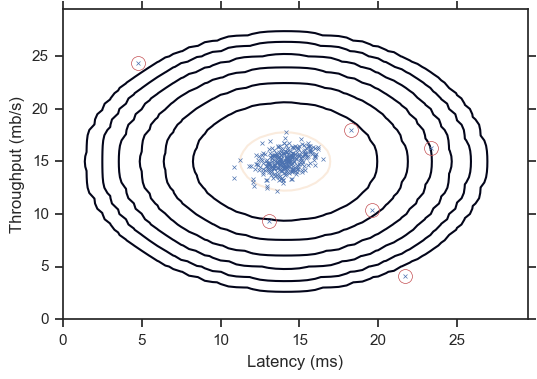

In [7]:
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set:  {}'.format(F1))
print('(A value epsilon of about 8.99e-05 is expected.)')

# Find the outliers in the training set and plot them.
outliers = p < epsilon

# Draw a red circle around those outliers.
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', markersize=10, fillstyle='none')
visualizeFit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

## High dimensional dataset

The anomaly detection algorithm will be applied now on a more realistic and much harder dataset. In this dataset, each example is described by $11$ features, capturing many more properties of the compute servers.

The code will estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$), evaluate the probabilities for both the training data $X$ from which the Gaussian parameters were estimated, and do so for the the cross-validation set $Xval$. Finally, the `selectThreshold` will be used to find the best threshold $\varepsilon$. A value epsilon of about $1.38e{-18}$, and $117$ anomalies shall be found.

In [8]:
# load data
data2 = loadmat('data/ex8data2.mat')
X2, Xval2, yval2 = data2['X'], data2['Xval'], data2['yval'].ravel()

# estimate Gaussian parameters
mu2, sigma2_2 = estimateGaussian(X2)

# evaluate probabilities for the training set 
p2 = multivariateGaussian(X2, mu2, sigma2_2)

# evaluate probabilities for the cross validation set
pval2 = multivariateGaussian(Xval2, mu2, sigma2_2)

# find the best threshold
epsilon2, F1_2 = selectThreshold(yval2, pval2)

print('Best epsilon found using cross-validation: %.2e' % epsilon2)
print('Best F1 on Cross Validation Set: {}'.format(F1_2))
print('# Outliers found: {}'.format(sum(p2 < epsilon2)))

Best epsilon found using cross-validation: 1.38e-18
Best F1 on Cross Validation Set: 0.6153846153846154
# Outliers found: 117


# Recommender Systems

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings ([MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/) from GroupLens Research). This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies.

In the next parts of this exercise, you will implement the function cofiCostFunc that computes the collaborative filtering objective function and gradient. After implementing the cost function and gradient, you will use scipy.optimize.minimize to learn the parameters for collaborative filtering.

## Movie ratings dataset

The next cell will load the dataset ex8_movies.mat, providing the variables Y and R. The matrix Y (a num_movies $\times$ num_users matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix R is an binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

To understand the matrix Y, the average movie rating will be computed for the first movie (Toy Story) and output the average rating to the screen.

The matrices, X and Theta will be also used:

$$ \text{X} = 
\begin{bmatrix}
- \left(x^{(1)}\right)^T - \\
- \left(x^{(2)}\right)^T - \\
\vdots \\
- \left(x^{(n_m)}\right)^T - \\
\end{bmatrix}, \quad
\text{Theta} = 
\begin{bmatrix}
- \left(\theta^{(1)}\right)^T - \\
- \left(\theta^{(2)}\right)^T - \\
\vdots \\
- \left(\theta^{(n_u)}\right)^T - \\
\end{bmatrix}.
$$

The $i^{th}$ row of X corresponds to the feature vector $x^{(i)}$ for the $i^{th}$ movie, and the $j^{th}$ row of Theta corresponds to one parameter vector $\theta^{(j)}$, for the $j^{th}$ user. Both $x^{(i)}$ and $\theta^{(j)}$ are n-dimensional vectors. For the purposes of this exercise, you will use $n = 100$, and therefore, $x^{(i)} \in \mathbb{R}^{100}$ and $\theta^{(j)} \in \mathbb{R}^{100}$. Correspondingly, X is a $n_m \times 100$ matrix and Theta is a $n_u \times 100$ matrix.

In [9]:
movie_data = loadmat('data/ex8_movies.mat')

Y, R = movie_data['Y'], movie_data['R']

# Y is a 1682x943 matrix, containing ratings (1-5) of 
# 1682 movies on 943 users

# R is a 1682x943 matrix, where R(i,j) = 1 
# if and only if user j gave a rating to movie i

Y.shape, R.shape

((1682, 943), (1682, 943))

Average rating for movie 1 (Toy Story): 3.878319 / 5


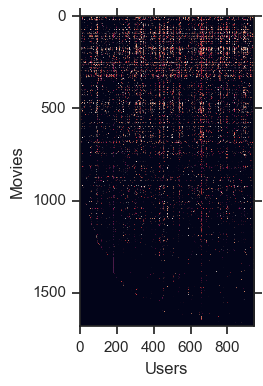

In [11]:
# From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5' % np.mean(Y[0, R[0, :] == 1]))

# We can "visualize" the ratings matrix by plotting it with imshow
plt.figure(figsize=(8, 4))
plt.imshow(Y)
plt.ylabel('Movies')
plt.xlabel('Users')
plt.grid(False)

## Collaborative filtering learning algorithm

Now, you will start implementing the collaborative filtering learning algorithm. You will start by implementing the cost function (without regularization).

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)}, \dots, x^{(n_m)}$ and $\theta^{(1)} , \dots, \theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = \left( \theta^{(j)} \right)^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

You will complete the code in cofiCostFunc to compute the cost function and gradient for collaborative filtering. Note that the parameters to the function (i.e., the values that you are trying to learn) are X and Theta. 

### Collaborative filtering cost function

The collaborative filtering cost function (without regularization) is given by

$$
J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2
$$

The function cofiCostFunc to return this cost in the variable $J$. Note that the cost should be accumulated for user $j$ and movie $i$ only if $R(i,j)=1$. An output cost of $22.22$ is expected.

**Implementation Note**: A vectorized implementation to compute $J$ is strongly recommended, since it will later by called many times by `scipy`'s optimization package. As usual, it might be easiest to first write a non-vectorized implementation (to make sure you have the right answer), and the modify it to become a vectorized implementation (checking that the vectorization steps do not change your algorithm’s output). To come up with a vectorized implementation, the following tip might be helpful: You can use the $R$ matrix to set selected entries to 0. For example, `R * M` will do an element-wise multiplication between `M` and `R`; since `R` only has elements with values either 0 or 1, this has the effect of setting the elements of M to 0 only when the corresponding value in R is 0. Hence, `np.sum(R * M)` is the sum of all the elements of `M` for which the corresponding element in `R` equals 1.

### Collaborative filtering gradient

Now the gradient (without regularization) will be implemented in coliCostFunc. The code will return the variables X_grad and Theta_grad. Note that X_grad should be a matrix of the same size as X and similarly, Theta_grad is a matrix of the same size as Theta. The gradients of the cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} $$$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} $$

Note that the function returns the gradient for both sets of variables by unrolling them into a single vector. 

**Implementation Note:** A vectorized implementation is recommended. The gradient can be implemented with a for-loop over movies (for computing $\frac{\partial J}{\partial x^{(i)}_k}$) and a for-loop over users (for computing $\frac{\partial J}{\theta_k^{(j)}}$). To perform the vectorization, it must be found a way to compute all the derivatives associated with $x_1^{(i)} , x_2^{(i)}, \dots , x_n^{(i)}$ (i.e., the derivative terms associated with the feature vector $x^{(i)}$ at the same time. The derivatives for the feature vector of the $i^{th}$ movie can be defined as:

$$ \left(X_{\text{grad}} \left(i, :\right)\right)^T = 
\begin{bmatrix}
\frac{\partial J}{\partial x_1^{(i)}} \\
\frac{\partial J}{\partial x_2^{(i)}} \\
\vdots \\
\frac{\partial J}{\partial x_n^{(i)}}
\end{bmatrix} = \quad
\sum_{j:r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right) \theta^{(j)}
$$

As previously noted, an element-wise multiplication with R is the trick. A similar method can be used to vectorize the derivatives with respect to $\theta^{(j)}$ as well.

In [12]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, reg=0.0):
    """
    Returns the cost and gradient for
    the collaborative filtering problem.
    Args:
        params      : array(num_movies x num_features + num_users x num_features,)
        Y           : array(num_movies, num_users)
        R           : array(num_movies, num_users)
        num_users   : int
        num_movies  : int
        num_features: int
        ref : float
    Returns:
        J           : float
        grad        : array(num_movies x num_features + num_users x num_features,)
    """
    
    # unroll the params back to X and Theta
    X = np.reshape(params[: num_movies * num_features], (num_movies, num_features))
    Theta = np.reshape(params[num_movies * num_features: ], (num_users, num_features))
    
    error = np.square(np.dot(X, Theta.T) - Y)
    
    if reg != 0.0:
        reg_err = (reg / 2) * (np.sum(Theta ** 2) + np.sum(X ** 2))
    else:
        reg_err = 0
    
    # sum only if R(i,j)=1
    cost = 1 / 2 * np.sum(error * R) + reg_err
    
    X_grad = np.dot((np.dot(X, Theta.T) - Y) * R, Theta) + reg * X
    Theta_grad = np.dot(((np.dot(X, Theta.T) - Y) * R).T, X) + reg * Theta

    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    
    return cost, grad

Next, we imported the pretrained weights to check whether the cofiCostFunc function has been implemented correctly. The expected output is $22.22$

In [13]:
#  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
params = loadmat('data/ex8_movieParams.mat')
X, Theta = params['X'], params['Theta']

num_users = 4
num_movies = 5
num_features = 3

X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, 0:num_users]
R = R[:num_movies, 0:num_users]

#  Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features)
           
print('Cost at loaded parameters:  %.2f \n(this value should be about 22.22)' % J)

Cost at loaded parameters:  22.22 
(this value should be about 22.22)


### Regularized cost function

The cost function for collaborative filtering with regularization is given by

$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2  \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$

### Regularized Gradient

The gradients for the regularized cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} + \lambda x_k^{(i)} $$$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} + \lambda \theta_k^{(j)} $$

A gradient check (checkCostFunction) will be applied to numerically check the implementation of your gradients (this is similar to the numerical check that you used in the neural networks exercise. If your implementation is correct, you should find that the analytical and numerical gradients match up closely.

In [14]:
# Create a function to compute numerical gradient.
def computeNumericalGradient(J, theta):
    """
    Computes the numerical gradient of the function J
    around theta using "finite differences" and gives
    a numerical estimate of the gradient.
    Notes: The following code implements numerical
           gradient checking, and returns the numerical
           gradient. It sets numgrad(i) to (a numerical 
           approximation of) the partial derivative of J
           with respect to the i-th input argument,
           evaluated at theta. (i.e., numgrad(i) should
           be the (approximately) the partial derivative
           of J with respect to theta(i).)
    Args:
        J      : function
        theta  : array(num_movies x num_features + num_users x num_features,)
    Returns:
        numgrad: array(num_movies x num_features + num_users x num_features,)
    """
    # Initialize parameters.
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4

    for p in range(theta.size):
        # Set the perturbation vector.
        perturb.reshape(perturb.size)[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        # Compute the Numerical Gradient.
        numgrad.reshape(numgrad.size)[p] = (loss2 - loss1) / (2 * e)
        perturb.reshape(perturb.size)[p] = 0
    
    return numgrad

# Create a function to check the cost function and gradients.
def checkCostFunction(lambda_coef):
    """
    Creates a collaborative filering problem 
    to check the cost function and gradients.
    It will output the analytical gradients
    and the numerical gradients computed using
    computeNumericalGradient. These two gradient 
    computations should result in very similar values.
    Args:
        lambda_coef : float
    """
    # Create small problem.
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)
    
    # Zap out most entries.
    Y = np.dot(X_t, Theta_t.T)
    Y[np.random.rand(Y.shape[0], Y.shape[1]) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    # Run Gradient Checking.
    X = np.random.randn(X_t.shape[0], X_t.shape[1])
    Theta = np.random.randn(Theta_t.shape[0], Theta_t.shape[1])
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]
    
    # Create short hand for cost function.
    def costFunc(p):
        return cofiCostFunc(p, Y, R, num_users, num_movies,
                            num_features, lambda_coef)

    params = np.concatenate((X.reshape(X.size), Theta.reshape(Theta.size)))
    numgrad = computeNumericalGradient(costFunc, params)
    J, grad = cofiCostFunc(params, Y, R, num_users, num_movies,
                           num_features, lambda_coef)
    
    # Visually examine the two gradient computations.
    for numerical, analytical in zip(numgrad, grad):
        print('Numerical Gradient: {0:10f}, Analytical Gradient {1:10f}'.\
              format(numerical, analytical))
    print('\nThe above two columns should be very similar.\n')
        
    # Evaluate the norm of the difference between two solutions.
    diff = np.linalg.norm(numgrad-grad) / np.linalg.norm(numgrad+grad)

    print('If the backpropagation implementation is correct, then \n' \
             'the relative difference will be small (less than 1e-9). \n' \
             '\nRelative Difference: {:.10E}'.format(diff))

In [15]:
print('Checking Gradients (without regularization)...\n')

J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features, 1.5)

print('Cost at loaded parameters (lambda_coef = 1.5): {:0.2f}'\
         '\n(this value should be 31.34)\n'.format(J))

print('Checking Gradients (with regularization)... \n')

# Check gradients by running checkCostFunction.
checkCostFunction(1.5)

Checking Gradients (without regularization)...

Cost at loaded parameters (lambda_coef = 1.5): 31.34
(this value should be 31.34)

Checking Gradients (with regularization)... 

Numerical Gradient:   0.864864, Analytical Gradient   0.864864
Numerical Gradient:   0.278275, Analytical Gradient   0.278275
Numerical Gradient:  -0.053374, Analytical Gradient  -0.053374
Numerical Gradient:   1.474949, Analytical Gradient   1.474949
Numerical Gradient:   0.711253, Analytical Gradient   0.711253
Numerical Gradient:  -5.281756, Analytical Gradient  -5.281756
Numerical Gradient:   2.381810, Analytical Gradient   2.381810
Numerical Gradient:  -1.361479, Analytical Gradient  -1.361479
Numerical Gradient:  -2.654675, Analytical Gradient  -2.654675
Numerical Gradient:  -1.635592, Analytical Gradient  -1.635592
Numerical Gradient:  -3.823496, Analytical Gradient  -3.823496
Numerical Gradient:  -0.317921, Analytical Gradient  -0.317921
Numerical Gradient:   2.961319, Analytical Gradient   2.961319
Nume

## Learning movie recommendations

Now, the algorithm can be trained to make movie recommendations. In the next cell, you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations. The list of all movies and their number in the dataset can be found listed in the file Data/movie_ids.txt.

In [16]:
# Create a function to load movies.
def loadMovieList():
    """
    Reads the fixed movie list in movie_idx.txt
    and returns a cell array of the words in movieList.
    Returns:
        movieList: list
    """
    # Read the fixed movieulary list.
    with open('data/movie_ids.txt', encoding = "ISO-8859-1") as f:
        movieList = []
        for line in f:
            movieName = line.split()[1:]
            movieList.append(" ".join(movieName))

    return movieList

movieList = loadMovieList()

#  Initialize my ratings
my_ratings = np.zeros(len(movieList))

# Check the file movie_ids.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
# Note that the index here is ID-1, since we start index from 0.
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# Select a few movies and rate them:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:')
print('-----------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

New user ratings:
-----------------
Rated 4 stars: Toy Story (1995)
Rated 3 stars: Twelve Monkeys (1995)
Rated 5 stars: Usual Suspects, The (1995)
Rated 4 stars: Outbreak (1995)
Rated 5 stars: Shawshank Redemption, The (1994)
Rated 3 stars: While You Were Sleeping (1995)
Rated 5 stars: Forrest Gump (1994)
Rated 2 stars: Silence of the Lambs, The (1991)
Rated 4 stars: Alien (1979)
Rated 5 stars: Die Hard 2 (1990)
Rated 5 stars: Sphere (1998)


### Recommendations

After the additional ratings have been added to the dataset, the script will proceed to train the collaborative filtering model. This will learn the parameters $X$ and $Theta$. To predict the rating of movie $i$ for user $j$, you need to compute $(\theta^{(j)})^{T}x^{(i)}$. The next part of the script computes the ratings for all the movies and users and displays the movies that it recommends, according to ratings that were entered earlier. Note that you might obtain a different set of the predictions due to different random initializations.

In [17]:
Y, R = movie_data['Y'], movie_data['R']

Y.shape, R.shape

((1682, 943), (1682, 943))

In [18]:
#  Add our own ratings to the data matrix
Y = np.c_[my_ratings[:, None], Y]
R = np.c_[(my_ratings > 0)[:, None], R]

# Create a function to normalize ratings.
def normalizeRatings(Y, R):
    """
    Preprocesses data by subtracting mean rating for every
    movie (every row). Normalizes Y so that each movie has
    a rating of 0 on average, and returns the mean rating in Ymean.
    Args:
        Y    : array(num_movies, num_users)
        R    : array(num_movies, num_users)
    Returns:
        Ynorm: array(num_movies, num_users)
        Ymean: array(num_movies, 1)
    """
    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = R[i, :] == 1
        # Compute the mean only of the rated movies.
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean

print('Training collaborative filtering...')

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

print(Ynorm.mean())

#  Useful Values
num_movies, num_users = Y.shape
num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 100, 'disp': True}

# Set Regularization
reg = 10
res = minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, reg),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = np.reshape(theta[: num_movies * num_features], (num_movies, num_features))
Theta = np.reshape(theta[num_movies * num_features: ], (num_users, num_features))

print('Recommender system learning completed.')

Training collaborative filtering...
5.46228654118e-19
Recommender system learning completed.


### Recommendation for me

After training the model, you can now make recommendations by computing the predictions matrix.

In [19]:
pred = np.dot(X, Theta.T)

# Get first column (my predictions) and add Ymean.
my_predictions = pred[:, 0] + Ymean.ravel()

# Reverse sort by index.
ix = my_predictions.argsort()[::-1]

ix.shape

(1682,)

In [20]:
my_predictions[ix][:10]

array([ 5.00201859,  5.00171845,  5.00149773,  5.0007636 ,  4.99998197,
        4.9989967 ,  4.9964098 ,  4.9962663 ,  4.99582219,  4.99389749])

In [21]:
print('Top 10 recommendations for me:\n')
for i in range(10):
    j = ix[i]
    print('Predicting rating {:0.2f} for movie {}'.\
          format(my_predictions[j], movieList[j]))

print('\n\nOriginal ratings provided:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {} for {}'.\
              format(int(my_ratings[i]), movieList[i]))

Top 10 recommendations for me:

Predicting rating 5.00 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.00 for movie They Made Me a Criminal (1939)
Predicting rating 5.00 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.00 for movie Someone Else's America (1995)
Predicting rating 5.00 for movie Star Kid (1997)
Predicting rating 5.00 for movie Great Day in Harlem, A (1994)
Predicting rating 5.00 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.00 for movie Prefontaine (1997)
Predicting rating 5.00 for movie Santa with Muscles (1996)
Predicting rating 4.99 for movie Aiqing wansui (1994)


Original ratings provided:

Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for